In [1]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

from Dataset import Dataset, saveDataset, loadDataset
from CNN_Model import CNN_Model, loadModel, saveModel
from ECOC_Classifier import ECOC_Classifier
from Stage import Stage
from Staged_Network import Staged_Network, saveStagedModel, loadStagedModel
from Utils import *

from localization_utilities import *
from main import *

from keras.models import Sequential, Graph, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.advanced_activations import PReLU

# Import Selective Search code
selsearch_root = '/home/lifelogging/code/selective_search'
import sys
sys.path.insert(0, selsearch_root)
import sel_search

import os
import logging
import copy
from operator import add
import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
from skimage.transform import resize

logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(message)s', datefmt='%d/%m/%Y %H:%M:%S')

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 3007)
/home/lifelogging/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [663]:
# Path to the produced evaluation measures
path_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_val'

# Load list of classes
path_classes = '/media/HDD_2TB/DATASETS/UECFOOD256_recognition/classes.txt'
classes = []
with open(path_classes, 'r') as list_c:
    for line in list_c:
        line = line.rstrip('\n')
        classes.append(line)

In [664]:
# Load all the necessary data
prec = np.load(path_data+'/precisions.npy')
rec = np.load(path_data+'/recalls.npy')
acc = np.load(path_data+'/accuracies.npy')
nGT = np.load(path_data+'/num_GT.npy')
nPred = np.load(path_data+'/num_predictions.npy')

prec_c = np.load(path_data+'/precisions_classes.npy')
rec_c = np.load(path_data+'/recalls_classes.npy')
acc_c = np.load(path_data+'/accuracies_classes.npy')
nGT_c = np.load(path_data+'/num_GT_classes.npy')
nPred_c = np.load(path_data+'/num_predictions_classes.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
params = np.load(path_data+'/params_cross_val.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
reports = np.load(path_data+'/reports.npy') 


###### ROUND 2 data
prec_r2 = np.load(path_data+'/precisions_GAP.npy')
rec_r2 = np.load(path_data+'/recalls_GAP.npy')
acc_r2 = np.load(path_data+'/accuracies_GAP.npy')
nGT_r2 = np.load(path_data+'/num_GT_GAP.npy')
nPred_r2 = np.load(path_data+'/num_predictions_GAP.npy')
prec_c_r2 = np.load(path_data+'/precisions_classes_GAP.npy')
rec_c_r2 = np.load(path_data+'/recalls_classes_GAP.npy')
acc_c_r2 = np.load(path_data+'/accuracies_classes_GAP.npy')
nGT_c_r2 = np.load(path_data+'/num_GT_classes_GAP.npy')
nPred_c_r2 = np.load(path_data+'/num_predictions_classes_GAP.npy')
params_r2 = np.load(path_data+'/params_cross_val_GAP.npy')
reports_r2 = np.load(path_data+'/reports_GAP.npy') 

ValueError: operands could not be broadcast together with shapes (150,) (750,) 

In [665]:
##### join tests
prec = list(prec_r2) + list(prec)
rec = list(rec_r2) + list(rec)
acc = list(acc_r2) + list(acc)
nGT = list(nGT_r2) + list(nGT)
nPred = list(nPred_r2) + list(nPred)
prec_c = list(prec_c_r2) + list(prec_c)
rec_c = list(rec_c_r2) + list(rec_c)
acc_c = list(acc_c_r2) + list(acc_c)
nGT_c = list(nGT_c_r2) + list(nGT_c)
nPred_c = list(nPred_c_r2) + list(nPred_c)
params = list(params_r2) + list(params)
reports = list(reports_r2) + list(reports)

In [667]:
prec = np.array(prec)
rec = np.array(rec)
acc = np.array(acc)
nGT = np.array(nGT)
nPred = np.array(nPred)
prec_c = np.array(prec_c)
rec_c = np.array(rec_c)
acc_c = np.array(acc_c)
nGT_c = np.array(nGT_c)
nPred_c = np.array(nPred_c)
params = np.array(params)
reports = np.array(reports)

## Choose best combination of parameters

In [668]:
# Get test settings with best average accuracy when comparing all IoU thresholds
len_sequence_IoU = 6
valid = acc.shape[0]-acc.shape[0]%len_sequence_IoU

acc__ = np.reshape(acc[:valid], (valid/6,6))
best_ind = np.argmax(np.mean(acc__, axis=1))*6
print best_ind

# Get test settings with best absolute recall
best_ind_ = np.argmax(rec)
print best_ind_

# Get test settings with best average recall when comparing all IoU thresholds
len_sequence_IoU = 6
rec__ = np.reshape(rec[:valid], (valid/6,6))
best_ind_ = np.argmax(np.mean(rec__, axis=1))*6
print best_ind_

print "Best test position: " + str(best_ind)
print "Best accuracy: " +str(acc[best_ind])
print "Best precision: " +str(prec[best_ind])
print "Best recall: " +str(rec[best_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print params[best_ind]

best_params = params[best_ind]
best_reports = reports[best_ind]

420
72
30
Best test position: 420
Best accuracy: 0.610153256705
Best precision: 0.845949535193
Best recall: 0.686422413793
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  4.00000000e-01   1.00000000e-01   2.00000000e-01   5.00000000e-01
   9.99900000e+03]


## Generate Precision-Recall curve

In [5]:
path_imgs = '/media/HDD_2TB/DATASETS/UECFOOD256'
test_list = 'val_list.txt'

# CAMs path
maps_dir = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_val'

# Recognition model
model_path_rec = '/media/HDD_2TB/CNN_MODELS/GoogleNet_UECFood256/finetuning_Food101_NoFood'
iter_rec = 27900
n_classes = 257

In [6]:
# Load dataset for pre-processing test images
ds = loadDataset('Datasets/Dataset_FoodVsNoFood.pkl')
# Load UEC detection test set
[ds, samples_detection] = loadUECDetectionTest(ds, path_imgs, test_list)
# Load predictions from GAP model
predictions = np.load(maps_dir+'/predictions.npy')

In [7]:
# Load recognition model
#net = None # not applying recognition right now
net = loadModel(model_path_rec, iter_rec)

#### Test with best params and increasing the number of picked samples at each iteration for computing the curve

In [35]:
parameters = dict()
parameters['percentage_heat'] = best_params[0]
parameters['size_restriction'] = best_params[1]
parameters['box_expansion'] = best_params[2]
parameters['IoU'] = best_params[3]
iou_values = np.arange(0.5,1.01,0.1)
iou_values = [0.5]
n_bboxes = [1,2,20]
#n_bboxes = [1]

# Iterate picking one more samples each iteration and use the pre-calculated reports
list_measures = []
list_measures_classes = []
for iou in iou_values:
    for nbb in n_bboxes:
        parameters['n_bboxes'] = nbb
        parameters['IoU'] = iou
        print 'parameters = '+str(parameters)
        [general_measures, class_measures, report_classes] = computePrecisionRecall(net, n_classes, ds, maps_dir, \
                                                                         samples_detection, predictions, \
                                                                         parameters)#, report_all=best_reports)
        print general_measures
        print
        list_measures.append(general_measures)
        #[prec_classes, rec_classes, acc_classes, total_GT_classes, total_pred_classes] = class_measures
        list_measures_classes.append(class_measures)

parameters = {'n_bboxes': 1, 'box_expansion': 0.20000000000000001, 'IoU': 0.5, 'size_restriction': 0.10000000000000001, 'percentage_heat': 0.40000000000000002}
[0.8478695073235686, 0.6861530172413793, 0.6109378747901175, 3712, 3004]

parameters = {'n_bboxes': 2, 'box_expansion': 0.20000000000000001, 'IoU': 0.5, 'size_restriction': 0.10000000000000001, 'percentage_heat': 0.40000000000000002}
[0.8458983726336765, 0.6861530172413793, 0.6099137931034483, 3712, 3011]

parameters = {'n_bboxes': 20, 'box_expansion': 0.20000000000000001, 'IoU': 0.5, 'size_restriction': 0.10000000000000001, 'percentage_heat': 0.40000000000000002}
[0.8458983726336765, 0.6861530172413793, 0.6099137931034483, 3712, 3011]



## Use Selective Search for generating candidates

In [134]:
# Path to the produced evaluation measures
selpath_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/SelSearch_val'

# Load all the necessary data
detect_type = 'SelSearch'

selprec = np.load(selpath_data+'/precisions_'+detect_type+'.npy')
selrec = np.load(selpath_data+'/recalls_'+detect_type+'.npy')
selacc = np.load(selpath_data+'/accuracies_'+detect_type+'.npy')
selnGT = np.load(selpath_data+'/num_GT_'+detect_type+'.npy')
selnPred = np.load(selpath_data+'/num_predictions_'+detect_type+'.npy')

selprec_c = np.load(selpath_data+'/precisions_classes_'+detect_type+'.npy')
selrec_c = np.load(selpath_data+'/recalls_classes_'+detect_type+'.npy')
selacc_c = np.load(selpath_data+'/accuracies_classes_'+detect_type+'.npy')
selnGT_c = np.load(selpath_data+'/num_GT_classes_'+detect_type+'.npy')
selnPred_c = np.load(selpath_data+'/num_predictions_classes_'+detect_type+'.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
selparams = np.load(selpath_data+'/params_cross_val_'+detect_type+'.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
selreports = np.load(selpath_data+'/reports_'+detect_type+'.npy') 

In [135]:
print selnPred
selbest_ind = np.argmax(selacc)
print "Best test position: " + str(selbest_ind)
print "Best accuracy: " +str(selacc[selbest_ind])
print "Best precision: " +str(selprec[selbest_ind])
print "Best recall: " +str(selrec[selbest_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print selparams[selbest_ind]

selbest_params = selparams[selbest_ind]
selbest_reports = selreports[selbest_ind]

[645088 645088 645088 645088 645088 645088]
Best test position: 0
Best accuracy: 0.00557654811981
Best precision: 0.00557753360782
Best recall: 0.969288793103
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   5.00000000e-01
   9.99900000e+03]


In [29]:
parameters = dict()
parameters['percentage_heat'] = 0
parameters['size_restriction'] = 0
parameters['box_expansion'] = 0
parameters['IoU'] = selbest_params[3]
iou_values = np.arange(0.5, 1.01, 0.1)
#n_bboxes = np.arange(0,1000,1)
n_bboxes = [5]

# Iterate picking one more samples each iteration and use the pre-calculated reports
sellist_measures = []
for iou in iou_values:
    for nbb in n_bboxes:
        parameters['n_bboxes'] = nbb
        parameters['IoU'] = iou
        print 'parameters = '+str(parameters)
        [selgeneral_measures, selclass_measures, selreport] = computePrecisionRecall(net, n_classes, ds, selpath_data, \
                                                                         samples_detection, [], \
                                                                         parameters, detect_type='SelSearch')
                                                                         #, report_all=best_reports)
        print selgeneral_measures
        print 
        sellist_measures.append(selgeneral_measures)
        #[selprec, selrec, selacc, seltotal_GT, seltotal_pred] = selgeneral_measures
        #[selprec_classes, selrec_classes, selacc_classes, seltotal_GT_classes, seltotal_pred_classes] = selclass_measures

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.5, 'size_restriction': 0, 'percentage_heat': 0}
[0.13335098986956234, 0.5425646551724138, 0.11987381703470032, 3712, 15103]

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.59999999999999998, 'size_restriction': 0, 'percentage_heat': 0}
[0.07826259683506588, 0.31842672413793105, 0.06703340327794476, 3712, 15103]

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.69999999999999996, 'size_restriction': 0, 'percentage_heat': 0}
[0.040389326623849565, 0.16433189655172414, 0.03350727822026916, 3712, 15103]

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.79999999999999993, 'size_restriction': 0, 'percentage_heat': 0}
[0.02112163146394756, 0.0859375, 0.0172469723183391, 3712, 15103]

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.89999999999999991, 'size_restriction': 0, 'percentage_heat': 0}
[0.006223929020724359, 0.025323275862068964, 0.005021099300251055, 3712, 15103]

parameters = {'n_bboxes'

### Plot some examples

In [ ]:
#id_img = 2376
#windows = sel_search.get_windows([samples_detection['list_imgs'][id_img]])
#windows = np.load(selpath_data +'/'+ samples_detection['all_ids'][id_img] +'_windows.npy')

[ [[4.6999999999999957, 24.599999999999998, 464.30000000000001, 341.40000000000003]]
 [] [0.49154490201708062] [[48.0, 15.0, 352.0, 345.0]] [53]]


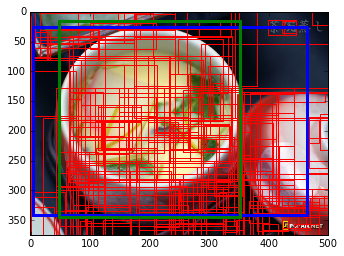

In [136]:
id_img = 2376
im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

# Selective Search result
#### BEWERE! we are using stored reports instead of the last output
selreport = selreports[selbest_ind]
for box in selreport[id_img][0]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='red'))

# FoodVsNoFood GoogleNet-GAP result
#### BEWERE! we are using stored reports instead of the last output
report = reports[best_ind]
print report[id_img]
for box in report[id_img][0]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
    
# Ground Truth
for box in report[id_img][3]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))

/media/HDD_2TB/DATASETS/UECFOOD256/3/215.jpg
[[[72.0, 58.399999999999999, 223, 170]], [86], [0.74948174], [[0.0, 49.0, 224.0, 171.0]], [3]]


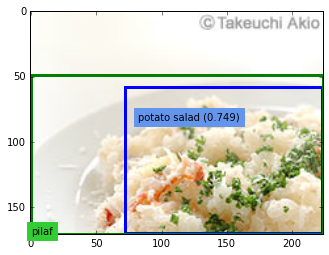

In [669]:
id_img = 678 # example of misclassification
id_img = 592 # example of misclassification
id_img = 53 # example of misclassification
id_img = 645 # example of misclassification
id_img = 2005 # example of misclassification
id_img = 53 # good example of missclassification but could be considered good given the GT segmentation and the type of food
id_img = 105 # good example of good classification but differently defined GT BBoxes
id_img = 125 # good

id_img = 1254

print samples_detection['list_imgs'][id_img]
im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

# Selective Search result
#### BEWERE! we are using stored reports instead of the last output
#selreport = selreports[selbest_ind]
#for box in selreport[id_img][0]:
#    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3],-box[1] facecolor="none", edgecolor='red'))

# FoodVsNoFood GoogleNet-GAP result
print report_classes[id_img]
for box, y, prob in zip(report_classes[id_img][0], report_classes[id_img][1], report_classes[id_img][2]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
    ax.text(box[0]+10, box[1]+25, classes[y] + ' (' + str(prob)[:5] + ')', backgroundcolor='cornflowerblue')
    
# Ground Truth
for box, y in zip(report_classes[id_img][3], report_classes[id_img][4]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))
    ax.text(box[0], box[3], classes[y], backgroundcolor='limegreen')

#### Plot Recall/Precision/Accuracy vs IoU

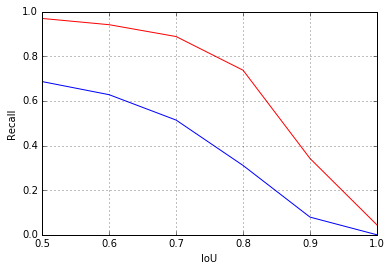

In [674]:
sequence = [best_ind, best_ind+6]
selsequence = [selbest_ind, selbest_ind+6]

# Plot data
plt.plot(rec[sequence[0]:sequence[1]], color='blue')
plt.plot(selrec[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Recall')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

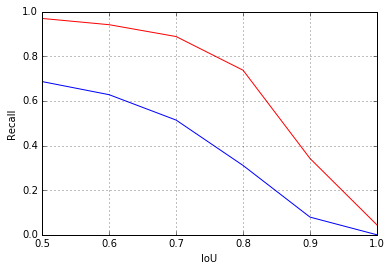

In [144]:
sequence = [best_ind, best_ind+6]
selsequence = [selbest_ind, selbest_ind+6]

selrec_ = []
for elem in sellist_measures:
    selrec_.append(elem[0])

# Plot data
plt.plot(rec[sequence[0]:sequence[1]], color='blue')
#plt.plot(selrec_[selsequence[0]:selsequence[1]], color='red')
plt.plot(selrec[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Recall')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

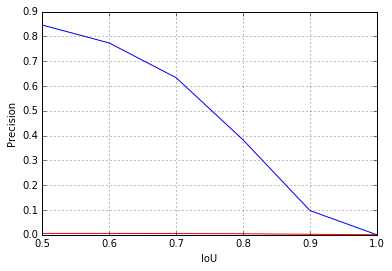

In [671]:
# Plot data
plt.plot(prec[sequence[0]:sequence[1]], color='blue')
plt.plot(selprec[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Precision')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

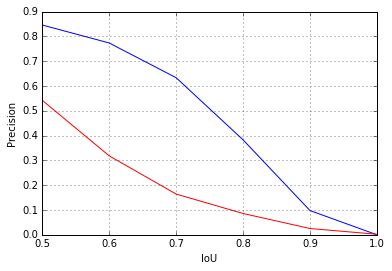

In [145]:
selprec_ = []
for elem in sellist_measures:
    selprec_.append(elem[1])

# Plot data
plt.plot(prec[sequence[0]:sequence[1]], color='blue')
plt.plot(selprec_[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Precision')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

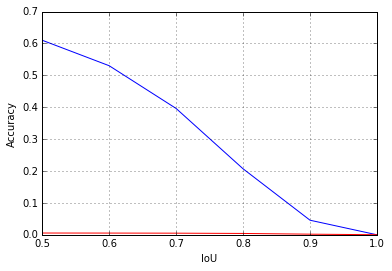

In [672]:
# Plot data
plt.plot(acc[sequence[0]:sequence[1]], color='blue')
plt.plot(selacc[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Accuracy')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

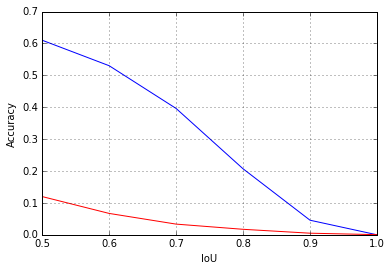

In [147]:
selacc_ = []
for elem in sellist_measures:
    selacc_.append(elem[2])


# Plot data
plt.plot(acc[sequence[0]:sequence[1]], color='blue')
plt.plot(selacc_[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Accuracy')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

## Detection methods time comparison (including image loading): SelSearch 0.8s per image, GAP 0.06s per image

In [21]:
np.mean(acc_, axis=1)

array([ 0.27952637,  0.27179805,  0.27091444,  0.27049986,  0.27043956,
        0.28041315,  0.27265419,  0.27176685,  0.27135066,  0.2712901 ,
        0.28076945,  0.27299817,  0.27210933,  0.2716925 ,  0.27163183,
        0.28082892,  0.27305559,  0.2721665 ,  0.27174955,  0.27168887,
        0.28088778,  0.27311132,  0.2722809 ,  0.27186374,  0.27180302,
        0.29643069,  0.28978627,  0.27939856,  0.27283214,  0.27068687,
        0.29780471,  0.29122126,  0.28075857,  0.27403193,  0.27176895,
        0.29788744,  0.29119009,  0.28076843,  0.27414888,  0.2719362 ,
        0.29808379,  0.29137841,  0.28094693,  0.27432186,  0.27210737,
        0.29821484,  0.2915041 ,  0.28106605,  0.2744373 ,  0.2722216 ,
        0.1468925 ,  0.23289768,  0.27552119,  0.28996736,  0.28507018,
        0.14765453,  0.23419578,  0.27695322,  0.29118727,  0.28605126,
        0.14797749,  0.23462971,  0.27737205,  0.29159107,  0.28648819,
        0.14816962,  0.23529388,  0.27830026,  0.29255059,  0.28

In [673]:
print np.mean(list_measures_classes[-1][0][1:]) # precision
print np.mean(list_measures_classes[-1][1][1:]) # recall
print np.mean(list_measures_classes[-1][2][1:]) # accuracy

0.548107968205
0.504481358002
0.366953850459
